In [1]:
import numpy as np

import dataset
import dataset_misc1d
import dataset_misc2d
from backprop import backprop
from backprop import lpbackprop
from backprop import jump_backprop
from backprop import constraints
from backprop import utils

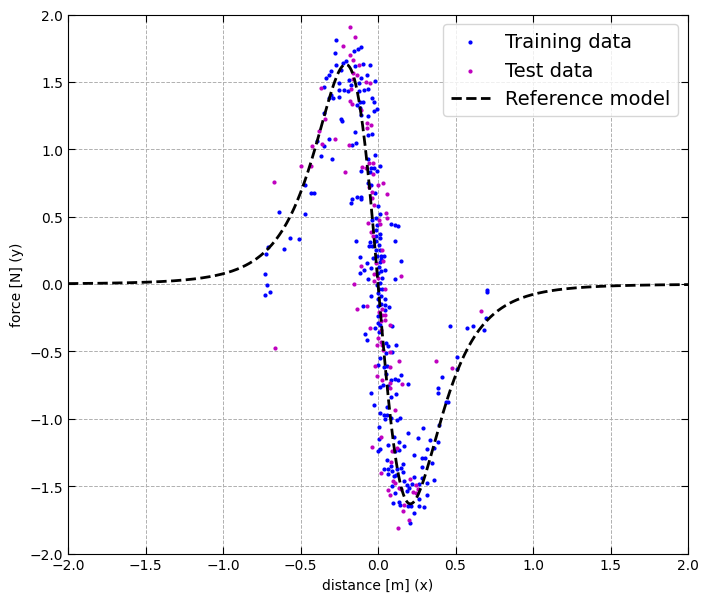

In [2]:
S = dataset_misc1d.MagmanDatasetScaled()
#S = dataset_misc2d.Resistance2()

#S.sample(size=50, noise=0.0, mesh=False)
S.load('../data/magman.csv')
S.split(train_size=0.7, randstate=0)
S.get_plotter().plot(width=8, height=7)

"""new_data = []
for dp in S.data:
    if dp.x < 0 and dp.y > 0 or \
       dp.x > 0 and dp.y < 0: new_data.append(dp)
S.data = new_data"""

S_train = dataset.NumpyDataset(S)
S_test  = dataset.NumpyDataset(S, test=True)

In [3]:
unknown_stree_a = backprop.UnknownSyntaxTree('A', nvars=S.nvars)
unknown_stree_b = backprop.UnknownSyntaxTree('B', nvars=S.nvars)
stree     = backprop.BinaryOperatorSyntaxTree('/', unknown_stree_a, unknown_stree_b)

#unknown_stree_a = backprop.UnknownSyntaxTree('A', nvars=S.nvars)
#stree     = backprop.BinaryOperatorSyntaxTree('/', backprop.VariableSyntaxTree(), unknown_stree_a)

#unknown_stree_a = backprop.UnknownSyntaxTree('A', nvars=S.nvars)
#stree     = backprop.BinaryOperatorSyntaxTree('/', backprop.VariableSyntaxTree(),
#    backprop.BinaryOperatorSyntaxTree('^', unknown_stree_a, backprop.ConstantSyntaxTree(3))
#    )

#unknown_stree_a = backprop.UnknownSyntaxTree('A', nvars=S.nvars)
#stree     = backprop.BinaryOperatorSyntaxTree('/',
#    unknown_stree_a,
#    backprop.BinaryOperatorSyntaxTree('+', backprop.VariableSyntaxTree(0), backprop.VariableSyntaxTree(1))
#    )

all_derivs = S.knowledge.get_derivs()
stree_map = backprop.SyntaxTree.diff_all(stree, all_derivs, include_zeroth=True)

for deriv, stree_deriv in stree_map.items():
    print(f"{deriv}: {stree_deriv}")

(): (A(x0) / B(x0))
(0,): (((d0A(x0) * B(x0)) - (A(x0) * d0B(x0))) / (B(x0) ^ 2))
(0, 0): ((((((d0d0A(x0) * B(x0)) + (d0A(x0) * d0B(x0))) - ((d0A(x0) * d0B(x0)) + (A(x0) * d0d0B(x0)))) * (B(x0) ^ 2)) - (((d0A(x0) * B(x0)) - (A(x0) * d0B(x0))) * ((2 * B(x0)) * d0B(x0)))) / (B(x0) ^ 4))


In [4]:
hist_set = []
best_unkn_models = {}
best_eval = None

def onsynth_callback(synth_unkn_models:dict):
    global hist_set
    global best_unkn_models
    global best_eval
    
    print('--- On Synth ---')
    for unkn in synth_unkn_models.keys():
        unkn_model, coeffs_mask, constrs = synth_unkn_models[unkn]
        print(f"{unkn}(x) =\n{unkn_model}")
    print()
    
    try:
        hist, __best_unkn_models, __best_eval = jump_backprop.jump_backprop(stree_map, synth_unkn_models, S_train, S_test, max_rounds=2)
        hist_set.append(hist)

        if best_eval is None or __best_eval.better_than(best_eval):
            best_unkn_models = __best_unkn_models
            best_eval = __best_eval
    except RuntimeError:
        pass

lpbackprop.lpbackprop(S.knowledge, stree, onsynth_callback)


--- ASP Model ---

sign_unkn("A","-",-4,-3)
sign_unkn("A","-",-3,-2)
sign_unkn("A","-",-2,-1)
sign_unkn("A","-",-1,0)
sign_unkn("A","+",0,1)
sign_unkn("A","+",1,2)
sign_unkn("A","+",2,3)
sign_unkn("A","+",3,4)
sign_unkn("B","-",-4,-3)
sign_unkn("B","-",-3,-2)
sign_unkn("B","-",-2,-1)
sign_unkn("B","-",-1,0)
sign_unkn("B","-",0,1)
sign_unkn("B","-",1,2)
sign_unkn("B","-",2,3)
sign_unkn("B","-",3,4)
sign_unkn("d0A","+",1,2)
sign_unkn("d0A","+",2,3)
sign_unkn("d0A","+",3,4)
sign_unkn("d0A","+",-4,-3)
sign_unkn("d0A","+",-3,-2)
sign_unkn("d0A","+",-2,-1)
sign_unkn("d0A","+",0,1)
sign_unkn("d0A","+",-1,0)
sign_unkn("d0B","-",1,2)
sign_unkn("d0B","-",2,3)
sign_unkn("d0B","-",3,4)
sign_unkn("d0B","+",-4,-3)
sign_unkn("d0B","+",-3,-2)
sign_unkn("d0B","+",-2,-1)
sign_unkn("d0B","-",0,1)
sign_unkn("d0B","+",-1,0)
sign_unkn("d0d0A","+",0,1)
sign_unkn("d0d0A","+",1,2)
sign_unkn("d0d0A","-",-4,-3)
sign_unkn("d0d0A","-",-3,-2)
sign_unkn("d0d0A","+",2,3)
sign_unkn("d0d0A","+",3,4)
sign_unkn("d0d0A",

(True, <backprop.lpbackprop.AspModelCost at 0x15866c92a90>)

--- Best Syntax Tree ---


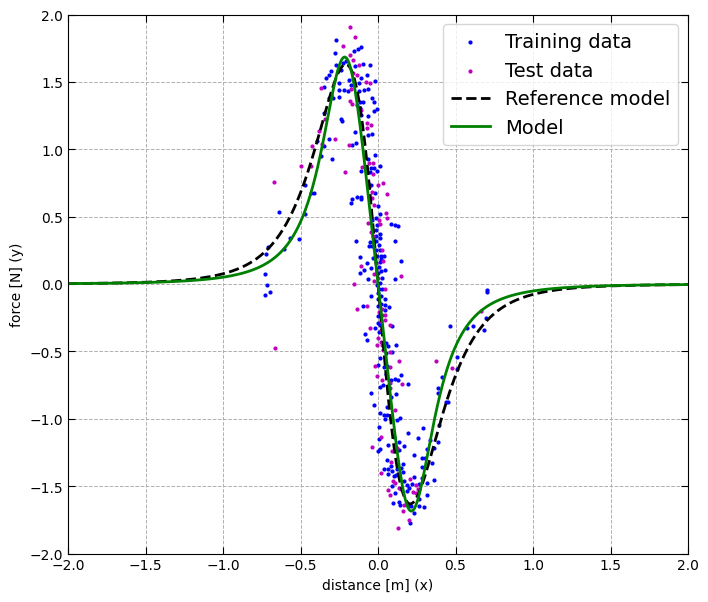

{'mse0': 8.164718157143927e-05, 'mse1': 0.02984748149830924, 'mse2': 10.337145725667774}
Training
	mse: 0.27012293133946363
	rmse: 0.5197335195457992
	r2: 0.7420818803797324
Testing
	mse: 0.31569039417756356
	rmse: 0.5618633233959692
	r2: 0.7032210142992348
Knowledge
	mse0: 8.164718157143927e-05
	mse1: 0.02984748149830924
	mse2: 10.337145725667774



In [5]:
##
## set all synth_unkn_models.
##
#for model_name in synth_unkn_models_set[0].keys():
#    stree.set_unknown_model(model_name, *synth_unkn_models_set[0][model_name])

#
# show best stree.
#
if best_eval is None:
    #_, best_r2 = S.evaluate(stree.compute_output)
    raise RuntimeError('No model found.')
else:
    for unkn_label in best_unkn_models.keys():
        stree.set_unknown_model(unkn_label, best_unkn_models[unkn_label])

print("--- Best Syntax Tree ---")
#import sympy
#print(sympy.print_latex(stree.to_sympy()))
#print(best_eval)
S.get_plotter().plot(width=8, height=7, model=stree)

k_eval = S.knowledge.evaluate(stree_map)
print(k_eval)
print(best_eval)


--- Pull from A(x0) ---


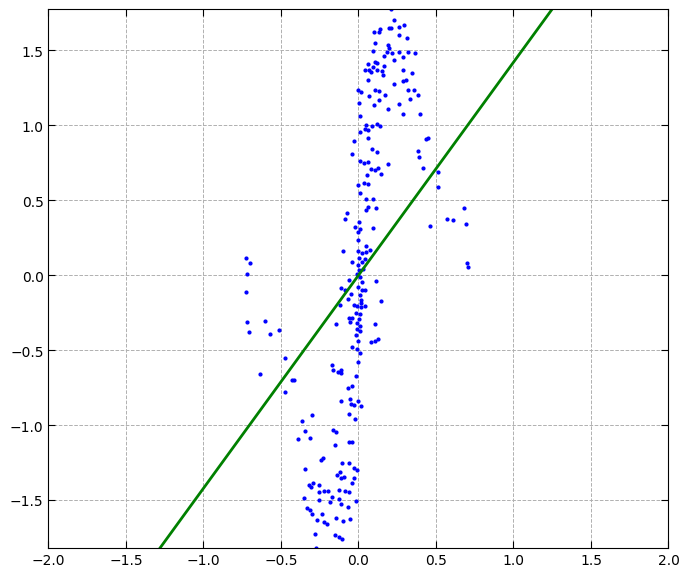

Model:
1.4209158197848*x
Coeffs Softmax:
[0.1147015 0.1147015 0.1147015 0.1147015 0.1147015 0.311791  0.1147015]
Coeffs:
[0.         0.         0.         0.         0.         1.42091582
 0.        ]
m(20,20) = [14.2091582]

--- Final Model ---


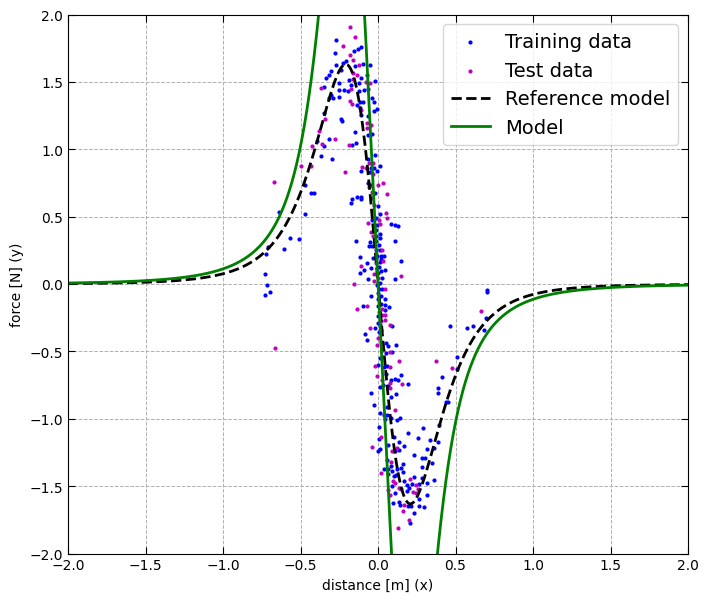



--- Pull from B(x0) ---


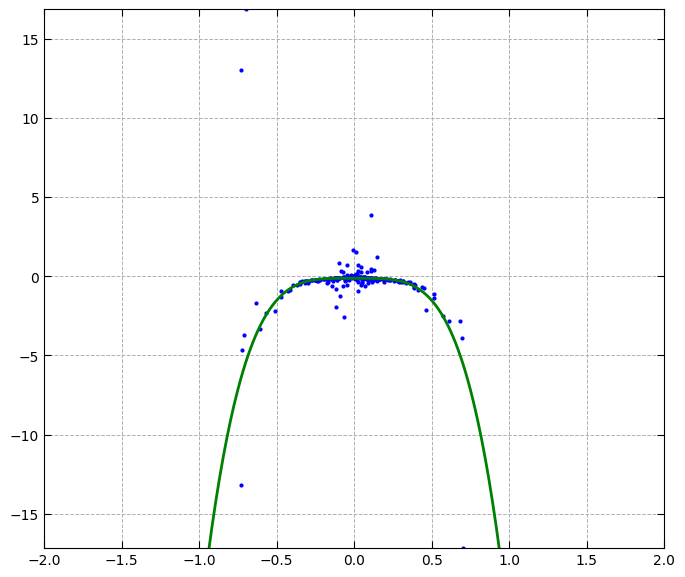

Model:
0.0890875632080031*x**6 - 22.2731367631782*x**4 - 0.130381861048551
Coeffs Softmax:
[0.15767376 0.15704686 0.05800493 0.15704686 0.15704686 0.15704686
 0.15613387]
Coeffs:
[  0.08908756   0.         -22.27313676   0.           0.
   0.          -0.13038186]
m(20,20) = [-133643.93480564]

--- Final Model ---


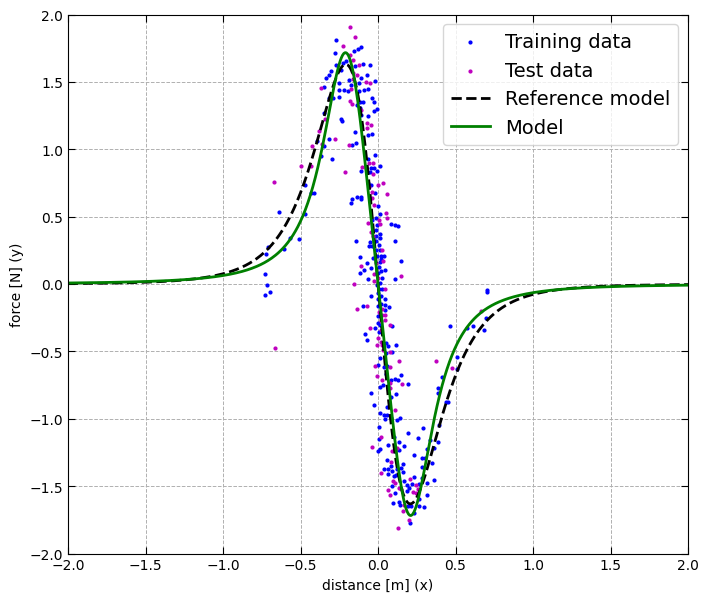



--- Pull from A(x0) ---


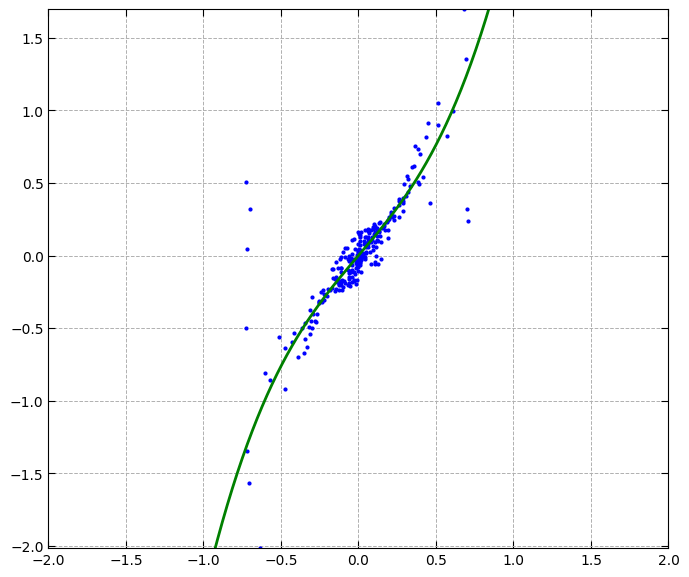

Model:
-0.00326309745286297*x**5 + 1.08776284153841*x**3 + 1.25268457919698*x
Coeffs Softmax:
[0.09914509 0.09888783 0.09914509 0.23572682 0.09914509 0.268805
 0.09914509]
Coeffs:
[ 0.         -0.0032631   0.          1.08776284  0.          1.25268458
  0.        ]
m(20,20) = [773.97994204]

--- Final Model ---


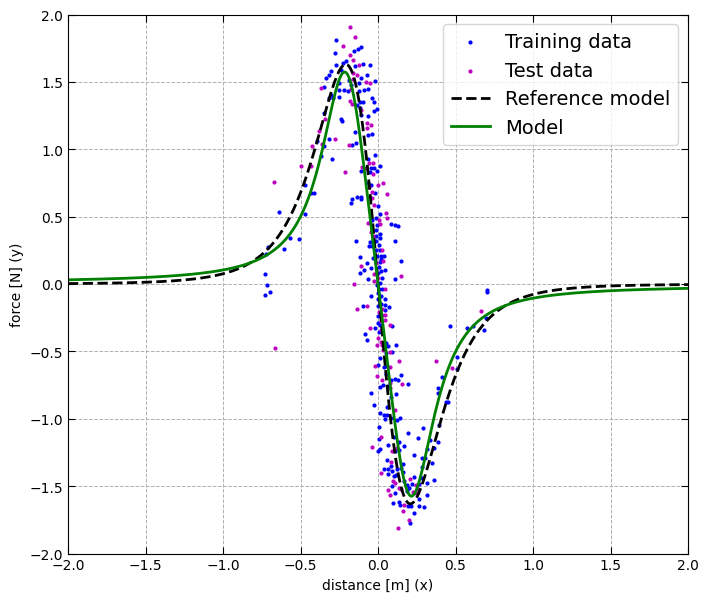



--- Pull from B(x0) ---


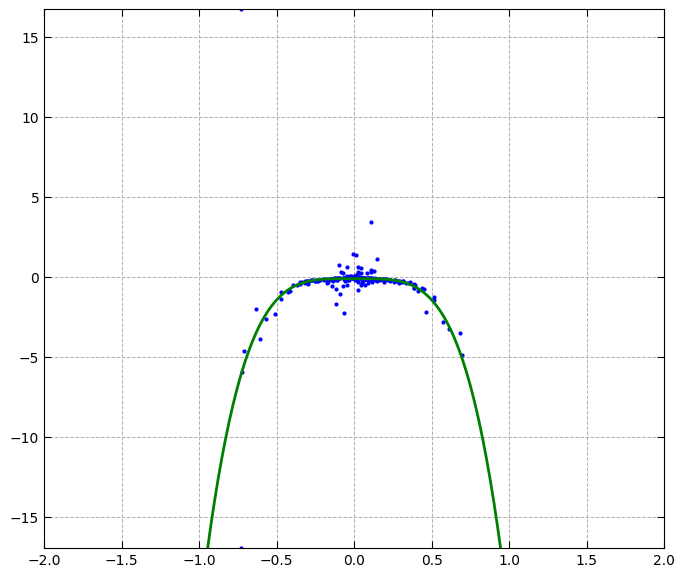

Model:
0.0848295746229873*x**6 - 21.2074245722024*x**4 - 0.12067948571181
Coeffs Softmax:
[0.15766978 0.15704286 0.05800347 0.15704286 0.15704286 0.15704286
 0.1561553 ]
Coeffs:
[  0.08482957   0.         -21.20742457   0.           0.
   0.          -0.12067949]
m(20,20) = [-127244.79177852]

--- Final Model ---


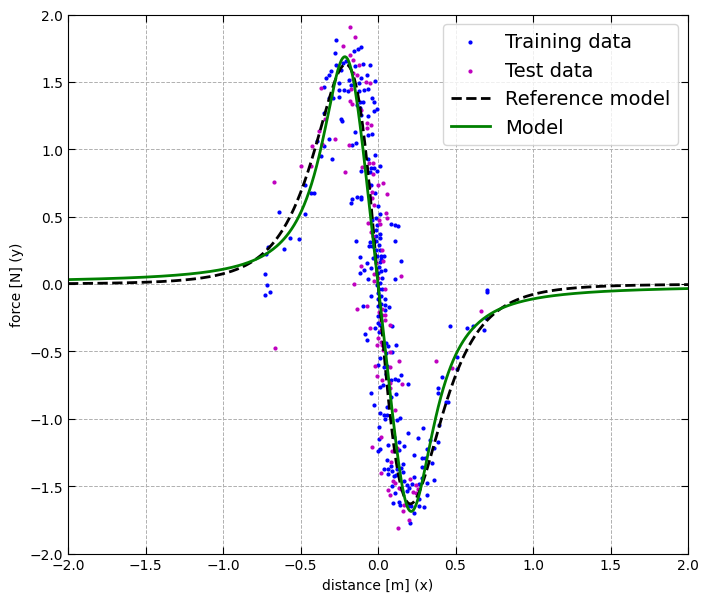



--- Pull from A(x0) ---


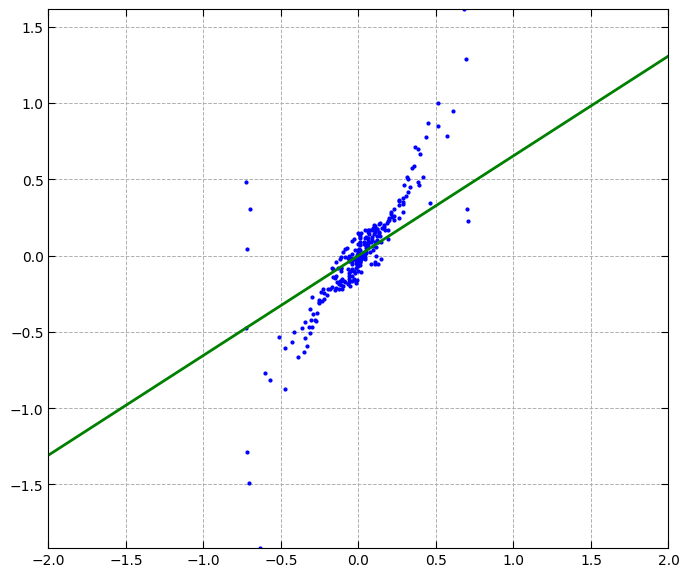

Model:
0.653943813052144*x
Coeffs Softmax:
[0.1147015 0.1147015 0.1147015 0.1147015 0.1147015 0.311791  0.1147015]
Coeffs:
[0.         0.         0.         0.         0.         0.65394381
 0.        ]
m(20,20) = [6.53943813]

--- Final Model ---


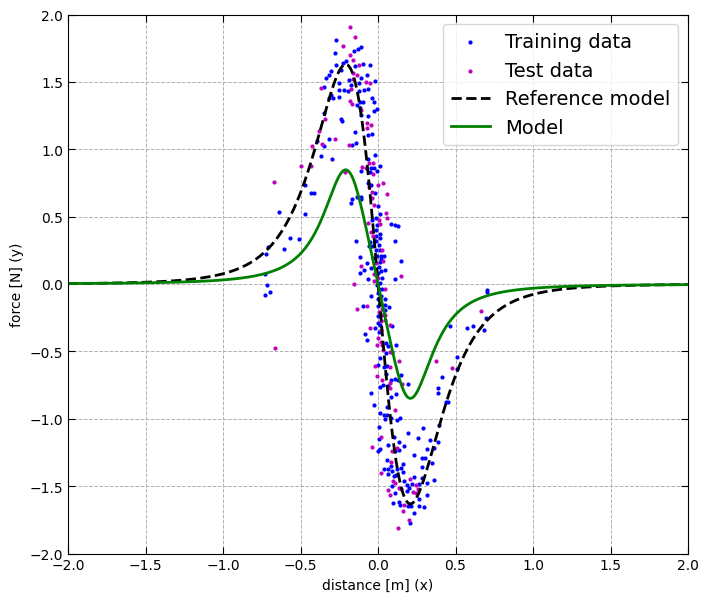



--- Pull from B(x0) ---


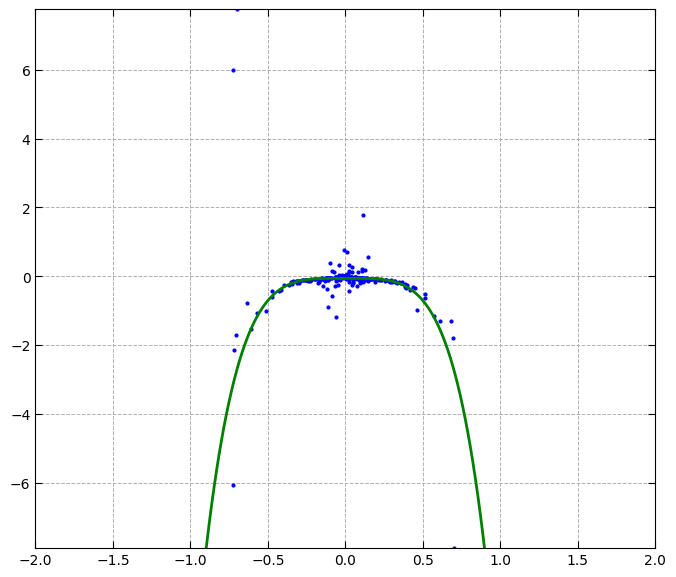

Model:
-3.16798825326675*x**6 - 9.51903121672478*x**4 - 0.0627470754476259
Coeffs Softmax:
[0.11794729 0.16452188 0.06052422 0.16452188 0.16452188 0.16452188
 0.16344096]
Coeffs:
[-3.16798825  0.         -9.51903122  0.          0.          0.
 -0.06274708]
m(20,20) = [-3263178.62818107]

--- Final Model ---


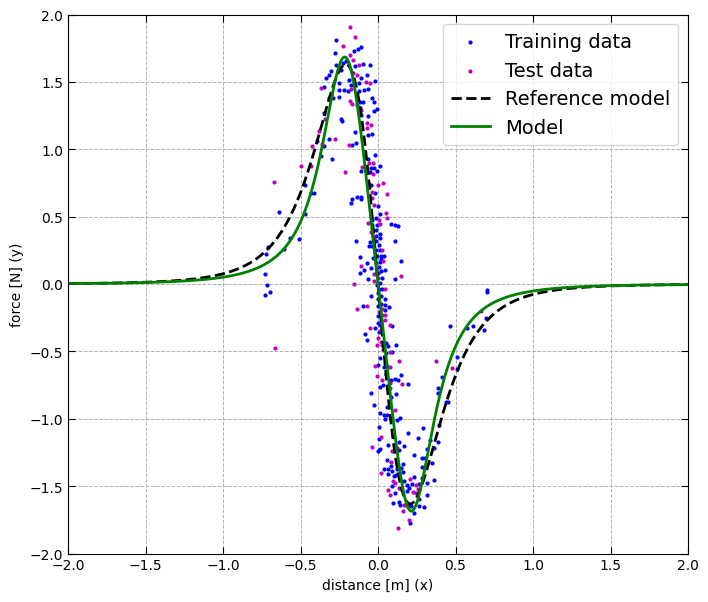



--- Pull from A(x0) ---


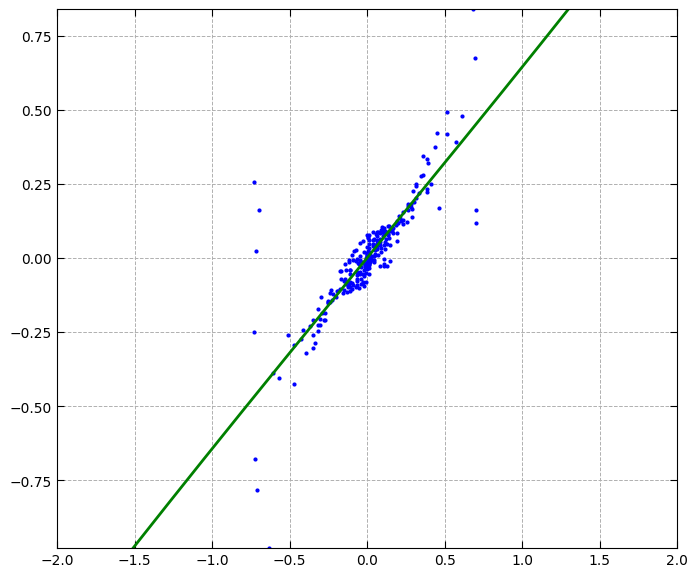

Model:
-1.06937724480837e-5*x**5 + 0.00356879568642974*x**3 + 0.639906374997634*x
Coeffs Softmax:
[0.11462879 0.11462687 0.11462879 0.11526985 0.11462879 0.31158814
 0.11462879]
Coeffs:
[ 0.00000000e+00 -1.06937724e-05  0.00000000e+00  3.56879569e-03
  0.00000000e+00  6.39906375e-01  0.00000000e+00]
m(20,20) = [8.89848219]

--- Final Model ---


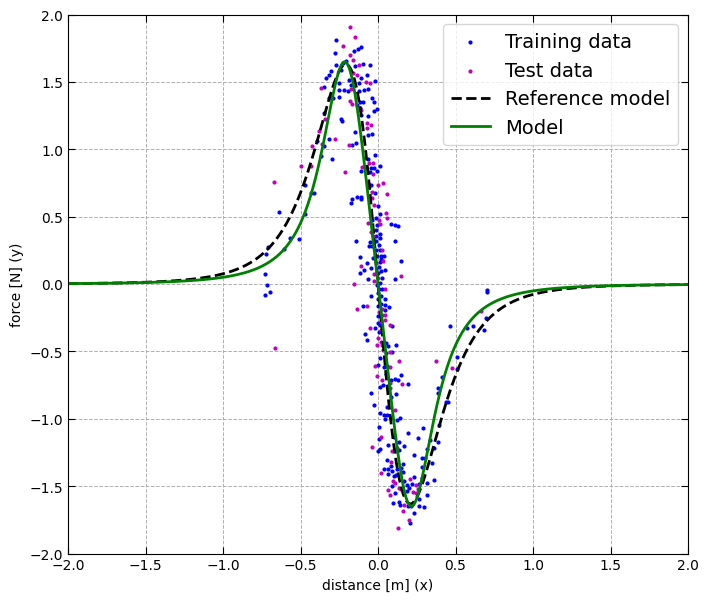



--- Pull from B(x0) ---


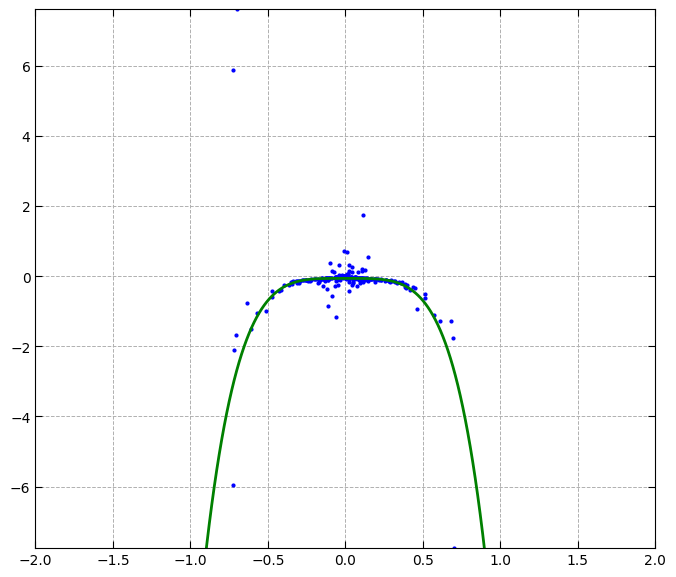

Model:
-3.22289863234284*x**6 - 9.30173244321606*x**4 - 0.0614538556350156
Coeffs Softmax:
[0.116532   0.16478632 0.0606215  0.16478632 0.16478632 0.16478632
 0.16370121]
Coeffs:
[-3.22289863  0.         -9.30173244  0.          0.          0.
 -0.06145386]
m(20,20) = [-3315916.01822886]

--- Final Model ---


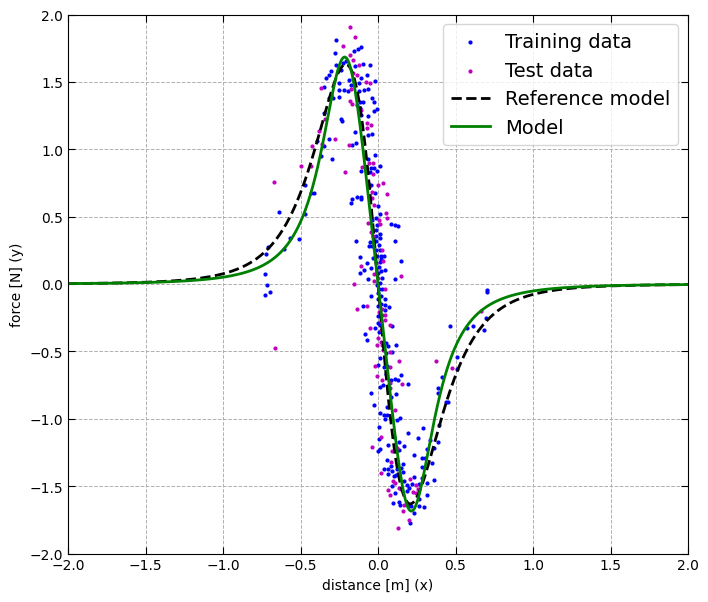

In [6]:
#
# show history (first Answer Set only).
#

constrmap = constraints.ConstraintMap()

for hist_entry in hist_set[0].entries:
    print(f"\n--- {hist_entry.msg} ---")
    
    if not hist_entry.pulled_S.is_empty():
        #y_scaled = utils.scale_y([dp.y for dp in hist_entry.pulled_S.data])
        #for i, dp in enumerate(hist_entry.pulled_S.data):
        #    dp.y = y_scaled[i]
        hist_entry.pulled_S.get_plotter().plot(width=8, height=7, model=hist_entry.fit_model)
        #xp = np.linspace(hist_entry.pulled_S.xl, hist_entry.pulled_S.xu, 500)
        #plt.plot(xp, hist_entry.fit_model(xp));
        #plt.xlim(S.xl, S.xu)
        #plt.ylim(S.yl, S.yu)

        #plt.show()
        #model, _ = utils.simplify_poly(hist_entry.fit_model, None)
        model = hist_entry.fit_model
        print(f"Model:\n{model}")
        print(f"Coeffs Softmax:\n{utils.coeffs_softmax(model.get_coeffs())}")
        print(f"Coeffs:\n{model.get_coeffs()}")
        print(f"m(20,20) = {model(np.array([[10, 10]]))}")

    """
    print("\n--- Pulled Eq/Ineq Constraints ---")
    for deriv in hist_entry.pulled_constrs.keys():
        for (dp, relopt) in hist_entry.pulled_constrs[deriv].eq_ineq:
            dp_x_str = "{:.8f}".format(dp.x)
            dp_y_str = str(dp.y) #"{:.8f}".format(dp.y)
            deriv_str = utils.deriv_to_string(deriv)
            constrmap.add(deriv_str + hist_entry.model_name, dp.x, dp.y, relopt)
            print(f"{hist_entry.model_name}{deriv_str}({dp_x_str}) {relopt.opt} {dp_y_str}")
    
    if len(hist_entry.violated_constrs) > 0:
        print("\n--- Violated Constraints ---")
        for (dp, relopt) in hist_entry.violated_constrs:
            dp_x_str = "{:.2f}".format(dp.x)
            dp_y_str = "{:.2f}".format(dp.y)
            print(f"m({dp_x_str}) {relopt.opt} {dp_y_str}")
    """

    print("\n--- Final Model ---")
    stree.set_unknown_model(hist_entry.model_name, hist_entry.fit_model)
    #model_eval = S.evaluate(stree.compute_output)
    #print(model_eval)
    
    S.get_plotter().plot(width=8, height=7, model=stree)

    print()